In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import models, layers, utils 
from sklearn import metrics, preprocessing
import os
import gc


import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

gc.collect()


211

In [2]:
path = "D:\\netflix dataset\\netflix-prize-data"


In [4]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')
    row = list()
    files = os.listdir(path)
    print(files)
    for file in files:
        if file.startswith('combined_data'):
        # if file.startswith('combined_data_1'):   # use this line to process only one file
            print("Reading ratings from {}\n".format(file))
            with open(os.path.join(path,file)) as f:
                for line in f:
                    line = line.strip()
                    if line.endswith(':'):
                        # All below are ratings for this movie, until another movie appears.
                        movie_id = line.replace(':', '')
                    else:
                        row = [x for x in line.split(',')]
                        row.insert(0, movie_id)
                        data.write(','.join(row))
                        data.write('\n')
data.close()
print('Time taken :', datetime.now() - start)


['combined_data_1.txt', 'combined_data_2.txt', 'combined_data_3.txt', 'combined_data_4.txt', 'movie_titles.csv', 'probe.txt', 'qualifying.txt', 'README']
Reading ratings from combined_data_1.txt

Time taken : 0:01:16.384216


In [3]:
df = pd.read_csv('data.csv', names=['Movie_Id', 'Cust_Id', 'Rating', 'Date'])


In [4]:
df.head()


,Movie_Id,Cust_Id,Rating,Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Movie_Id  int64 
 1   Cust_Id   int64 
 2   Rating    int64 
 3   Date      object
dtypes: int64(3), object(1)
memory usage: 3.0+ GB


In [6]:
df['Movie_Id'] = df['Movie_Id'].astype(np.uint32)
df['Cust_Id'] = df['Cust_Id'].astype(np.uint32)
df['Rating'] = df['Rating'].astype(np.uint8)
df.drop(['Date'], axis=1, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Movie_Id  uint32
 1   Cust_Id   uint32
 2   Rating    uint8 
dtypes: uint32(2), uint8(1)
memory usage: 862.4 MB


In [7]:
f = ['count', 'mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7), 0)
drop_movie_list = df_movie_summary[df_movie_summary['count']
                                   < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7), 0)
drop_cust_list = df_cust_summary[df_cust_summary['count']
                                 < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))


print("number of movies deleted is " , len(drop_movie_list))
print("number of customers deleted is " , len(drop_cust_list))

Movie minimum times of review: 1948.0
Customer minimum times of review: 211.0
Original Shape: (100480507, 3)
After Trim Shape: (71833509, 3)
number of movies deleted is  12438
number of customers deleted is  335809


In [8]:
# del df_cust_summary, df_movie_summary, drop_movie_list, drop_cust_list
gc.collect()
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 71833509 entries, 693 to 100479585
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Movie_Id  uint32
 1   Cust_Id   uint32
 2   Rating    uint8 
dtypes: uint32(2), uint8(1)
memory usage: 1.1 GB


In [9]:
df_title = pd.read_csv("D:\\netflix dataset\\netflix-prize-data\\movie_titles.csv", encoding="ISO-8859-1",
                        header=None, names=['Movie_Id', 'Year', 'Name'], usecols=[0, 1, 2])
df_title.set_index('Movie_Id', inplace=True)

df_title.head(10)


,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


In [10]:
df_pivot = pd.pivot_table(df, values='Rating',
                      index='Cust_Id', columns='Movie_Id')

print(df_pivot.shape)


(144380, 5332)


In [12]:
df_pivot.info()
# nearly 6 gb of ram is used by pivot table

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 144380 entries, 6 to 2649429
Columns: 5332 entries, 3 to 17769
dtypes: float64(5332)
memory usage: 5.7 GB


In [51]:
# min count is min count of ratings given by a customer
def get_similar_movies(movie_title, min_count = 0):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_pivot[i]
    similar_to_target = df_pivot.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns=['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    corr_target.rename(columns={"Name": "movie name", "count": "number of ratings"  , "mean": "average rating" ,
                                "PearsonR": "Pearson correlation coefficient"}, inplace=True)
    
    print(corr_target[corr_target['number of ratings']>min_count][1:11].to_string(index=False))

In [52]:
get_similar_movies("Lord of the Rings: The Fellowship of the Ring", 30000)
# you can see it outputs similar movies 


For movie (Lord of the Rings: The Fellowship of the Ring)
- Top 10 movies recommended based on Pearsons'R correlation - 
 Pearson correlation coefficient                                                          movie name  number of ratings  average rating
                        0.809049                                   Lord of the Rings: The Two Towers             151245        4.460676
                        0.756614                           Lord of the Rings: The Return of the King             134284        4.545121
                        0.691485 The Lord of the Rings: The Fellowship of the Ring: Extended Edition              73422        4.716611
                        0.657337                 Lord of the Rings: The Two Towers: Extended Edition              74912        4.702611
                        0.631096         Lord of the Rings: The Return of the King: Extended Edition              73335        4.723270
                        0.259167                               

In [53]:
get_similar_movies("Fight Club")
get_similar_movies("Fight Club", 80000)
# here it actually ouputs movies of the same genre or the the same director
# and min count produces better recommendations if used correctly

For movie (Fight Club)
- Top 10 movies recommended based on Pearsons'R correlation - 
 Pearson correlation coefficient                            movie name  number of ratings  average rating
                        0.380089                            12 Monkeys              76475        3.776084
                        0.378151                                Snatch              68818        3.848005
                        0.364983                               Memento             127318        3.851427
                        0.357912                          Pulp Fiction             152078        4.094235
                        0.347596                         Trainspotting              24446        3.885953
                        0.343847 Eternal Sunshine of the Spotless Mind             110159        3.695304
                        0.333834                        Reservoir Dogs              90450        4.003847
                        0.326851  The Royal Tenenbaums: Bonus Mate

In [54]:
get_similar_movies("Saving Private Ryan", 0)
# here it ouputs similar war movies


For movie (Saving Private Ryan)
- Top 10 movies recommended based on Pearsons'R correlation - 
 Pearson correlation coefficient        movie name  number of ratings  average rating
                        0.348649   Black Hawk Down              77597        3.859608
                        0.343554        Braveheart             135601        4.294423
                        0.328930         Apollo 13              98116        4.082576
                        0.321378         Gladiator             150592        4.202713
                        0.321019      Forrest Gump             181508        4.299910
                        0.315738  Band of Brothers              37514        4.513328
                        0.315564           Platoon              64175        3.986038
                        0.303892  We Were Soldiers              64917        4.005299
                        0.295405  Schindler's List             101141        4.458004
                        0.292609 Sands of Iwo

In [13]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])


{'test_rmse': array([0.95945732, 0.96090222, 0.9599608 , 0.96005118, 0.95973295]),
 'test_mae': array([0.7622917 , 0.76309682, 0.7625518 , 0.76276465, 0.76241396]),
 'fit_time': (113.20451712608337,
  116.81955790519714,
  112.04496645927429,
  105.27772545814514,
  113.24493336677551),
 'test_time': (47.689056396484375,
  33.096291303634644,
  34.603400468826294,
  29.052910089492798,
  29.621825218200684)}

1674

In [8]:

df1 = pd.read_csv(path + "\combined_data_4.txt", header=None, names=['Cust_Id', 'Rating'], usecols=[0, 1])
print(df1.shape)
df  = df1.copy()
del df1
df2=pd.read_csv(path + "\combined_data_3.txt", header = None, names = ['Cust_Id', 'Rating'], usecols = [0, 1])
print(df2.shape)
# df.append(df2)
pd.concat([df, df2], ignore_index=True)
del df2
df3=pd.read_csv(path + "\combined_data_2.txt", header=None, names=['Cust_Id', 'Rating'], usecols=[0, 1])
print(df3.shape)
pd.concat([df, df3], ignore_index=True)
del df3
df4=pd.read_csv(path + "\combined_data_1.txt", header=None, names=['Cust_Id', 'Rating'], usecols=[0, 1])
print(df4.shape)
pd.concat([df, df4], ignore_index=True)
del df4
print(df.shape)
df.head()



(26851926, 2)
(22605786, 2)
(26982302, 2)
(24058263, 2)
(26851926, 2)


,Cust_Id,Rating
0,13368:,NaN
1,2385003,4.0
2,659432,3.0
3,751812,2.0
4,2625420,2.0


In [9]:
df.index = np.arange(0, len(df))

print(df.iloc[::5000000, :])
df.head()

          Cust_Id  Rating
0          13368:     NaN
5000000    605496     5.0
10000000   285173     5.0
15000000   604335     5.0
20000000  2503632     5.0
25000000   470744     3.0


,Cust_Id,Rating
0,13368:,NaN
1,2385003,4.0
2,659432,3.0
3,751812,2.0
4,2625420,2.0


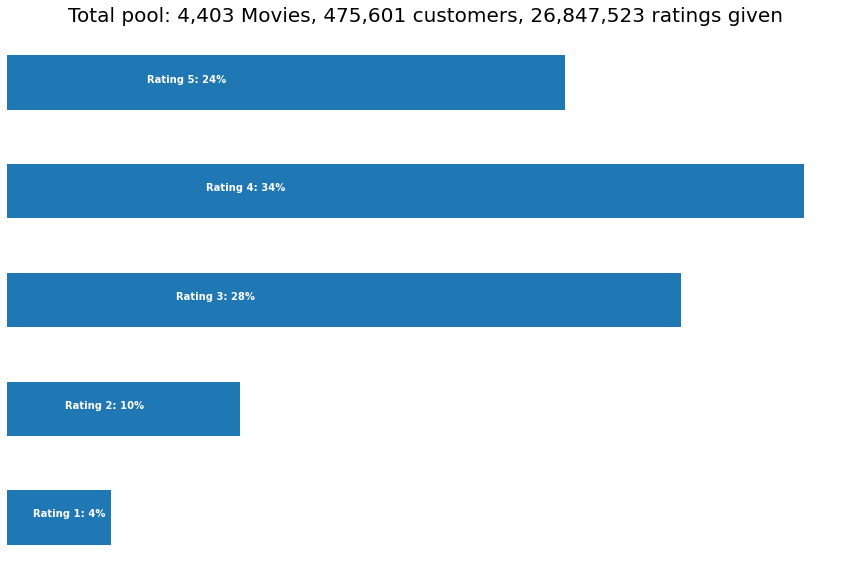

In [10]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind='barh', legend=False, figsize=(15, 10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(
    movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1, 6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i,
            p.iloc[i-1][0]*100 / p.sum()[0]), color='white', weight='bold')


In [11]:
df.head()

,Cust_Id,Rating
0,13368:,NaN
1,2385003,4.0
2,659432,3.0
3,751812,2.0
4,2625420,2.0


In [12]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i, j in zip(df_nan['index'][1:], df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1, i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1, len(df) - df_nan.iloc[-1, 0] - 1), movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))


Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.403e+03 4.403e+03 4.403e+03]
Length: 26847523


In [14]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


C:\Users\user\AppData\Local\Temp\ipykernel_22404\1628938347.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         2385003     4.0         1
5000907    495207     1.0       907
10001561  2243515     4.0      1561
15002391  2210687     5.0      2391
20003238  2088300     5.0      3238
25004038   717559     3.0      4038


C:\Users\user\AppData\Local\Temp\ipykernel_22404\1628938347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


In [15]:
f = ['count', 'mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7), 0)
drop_movie_list = df_movie_summary[df_movie_summary['count']
                                   < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7), 0)
drop_cust_list = df_cust_summary[df_cust_summary['count']
                                 < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))


Movie minimum times of review: 2044.0
Customer minimum times of review: 58.0


In [16]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])


Original Shape: (26847523, 3)
After Trim Shape: (19013865, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
680        132390     3.0         3
7033703   2571095     5.0      1171
14066453   791676     3.0      2211
21193983  1550718     5.0      3480


In [81]:
df.head()

,Cust_Id,Rating,Movie_Id
680,132390,3.0,3
681,613501,3.0,3
682,1116838,5.0,3
683,2445646,2.0,3
685,2059652,4.0,3


In [8]:

# df_p = pd.pivot_table(df, values='Rating', index='Cust_Id', columns='Movie_Id')

# print(df_p.shape)
# Below is another way I used to sparse the dataframe...doesn't seem to work better

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
# df_p = df_p.replace(0, np.NaN)


In [ ]:
df_p.head()


Movie_Id,3,11,12,15,16,17,21,22,24,25,...,4363,4374,4376,4384,4389,4391,4394,4395,4397,4402
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,5.0,5.0,4.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
97,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
movieData = pd.read_csv("D:\\netflix dataset\\netflix-prize-data\\movie_titles.csv", encoding="ISO-8859-1",
                        header=None, names=['Movie_Id', 'ReleaseYear', 'MovieName'] , usecols=[0, 1, 2])
movieData.head(100)

,Movie_Id,ReleaseYear,MovieName
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
95,96,2000.0,Inside the Space Station
96,97,2002.0,Mostly Martha
97,98,1965.0,The Battle of Algiers: Bonus Material
98,99,1989.0,A Fishy Story


In [45]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])


{'test_rmse': array([0.83698179, 0.83720805, 0.83779665, 0.83694197, 0.83720677]),
 'test_mae': array([0.64944896, 0.64930311, 0.64996931, 0.64907905, 0.64939165]),
 'fit_time': (267.89942502975464,
  275.9518699645996,
  275.8473930358887,
  276.0646479129791,
  276.8676884174347),
 'test_time': (109.97044372558594,
  80.90992021560669,
  93.02057886123657,
  81.08875894546509,
  81.70408368110657)}

In [48]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(movieData)['MovieName']
print(df_785314)


Movie_Id
11                                   My Favorite Brunette
24          Inspector Morse 31: Death Is Now My Neighbour
213                      Read-Along: Beauty and the Beast
417                                              The Deal
597                             Bobby Darin: Mack is Back
683                                 Visitors of the Night
825                            Goosebumps: Cry of the Cat
842                                        Mansfield Park
873       Elvis Costello & the Imposters: Live in Memphis
887                                 Discovering Australia
907                                 Sense and Sensibility
913                                    R.E.M.: Road Movie
935                A Dangerous Man: Lawrence After Arabia
945                              Sex and the Teenage Mind
975                     Tom and Jerry: Paws for a Holiday
991                                           The Cowboys
1043                                            The Party
1115 

In [66]:
user_785314 = movieData.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(
    lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis=1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))


      index  ReleaseYear                              MovieName  \
1374   1374       2002.0                           Food of Love   
872     872       2003.0                 Boys Life 4: Four Play   
2779   2779       1998.0                              Dark City   
179     179       2002.0                                Scratch   
934     934       2003.0                            Read Or Die   
3819   3819       2002.0                      Between Strangers   
1593   1593       1962.0                       Damn the Defiant   
3219   3219       2001.0  Xena: Warrior Princess: Series Finale   
188     188       1982.0                Airplane II: The Sequel   
3797   3797       1973.0                              The Sting   

      Estimate_Score  
1374        4.737913  
872         4.711479  
2779        4.701343  
179         4.696545  
934         4.695050  
3819        4.665386  
1593        4.618023  
3219        4.602311  
188         4.542947  
3797        4.526017  


In [73]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(movieData.index[movieData['MovieName'] == movie_title][0])
    print(i)
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(movieData).join(df_movie_summary)[
        ['PearsonR', 'MovieName', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [78]:
# recommend("What the #$*! Do We Know!?", 0)

# # recommend("X2: X-Men United", 0)
# recommend("Renegade", 0)

# recommend("Batman Begins", 0)

recommend("Justice League", 0)



For movie (Justice League)
- Top 10 movies recommended based on Pearsons'R correlation - 
47


KeyError: 47